In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import extract_features, EfficientFCParameters, MinimalFCParameters

from xgboost.sklearn import XGBRegressor
import xgboost as xgb
xgb.set_config(verbosity=0)
import random

from data_feature import *

plt.rcParams['font.sans-serif'] = ['SimHei']


def xgboot_reg(data, target):
    # 切分训练集和测试集
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.3, random_state=random.randint(1,10000))

    # xgboost模型初始化设置
    # dtrain = xgb.DMatrix(train_x, label=train_y)
    # dtest = xgb.DMatrix(test_x)
    # watchlist = [(dtrain, 'train')]

    # # 参数寻优
    # param_test1 = {
    #     'max_depth':[5, 10, 15, 20, 25],
    #     'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
    #     'min_child_weight':[1,3,5],
    #     'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
    # }
    #
    # gsearch1 = GridSearchCV(estimator= XGBRegressor(learning_rate =0.1,
    # n_estimators=140,
    # max_depth=4,
    # min_child_weight=5,
    # gamma=0,
    # subsample=0.8,
    # colsample_bytree=0.8,
    # objective= 'binary:logistic',
    # nthread=4,
    # scale_pos_weight=1,
    # seed=27),
    # param_grid = param_test1,
    # scoring='roc_auc',
    # n_jobs=4,
    # cv=5)
    #
    # gsearch1.fit(train_x,train_y)
    # print(gsearch1.best_params_,gsearch1.best_score_)
    # exit()

    # booster:
    # params = {'booster': 'gbtree',
    #           'objective': 'reg:logistic',  # binary:logistic
    #           'eval_metric': 'rmse',
    #           # 'objective': 'multi:softmax',  # 多分类的问题
    #           # 'num_class': 2,  # 类别数，与 multisoftmax 并用
    #           'max_depth': 6,
    #           'lambda': 2,
    #           'subsample': 0.75,
    #           'colsample_bytree': 0.75,
    #           'min_child_weight': 3,
    #           'eta': 0.05,
    #           'seed': random.randint(1,10000),
    #           'nthread': 8,
    #           'gamma': 0.15,
    #           'learning_rate': 0.02}

    # 建模与预测：50棵树
    # bst = xgb.train(params, dtrain, num_boost_round=500)
    # ypred = bst.predict(dtest)
    # print(ypred)

    bst = xgb.XGBRegressor(max_depth=6,learning_rate=0.05,n_estimators=100,randam_state=42)
    bst.fit(train_x, train_y, eval_metric='auc')
    ypred = bst.predict(test_x)

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8), dpi=100)
    # pred
    a = pd.Series(np.array(ypred))
    a.plot(ax=axes, legend=True, color='blue',label='pred')
    a1 = a.pct_change().fillna(method='ffill')
    a1 = list(a1.apply(lambda x: True if x>0 else False))
    # real
    b = pd.Series(np.array(test_y))
    b.plot(ax=axes, legend=True, color='red',label='real')
    b1 = b.pct_change().fillna(method='ffill')
    b1 = list(b1.apply(lambda x: True if x>0 else False))
    c = [True if a1[i]==b1[i] else False for i in range(len(a1))]
    print('预测准确率：{}'.format(c.count(True)/len(c)))

In [95]:
if __name__ == "__main__":
    print('data processing...')
    settings = MinimalFCParameters()
    # settings = EfficientFCParameters()
    df = pd.read_csv('./data1.csv', index_col=['bob'])
    df.drop(columns=['id', 'position', 'eob', 'frequency'], inplace=True)
    df['time'] = df.index

    # 滚动处理时间序列，指定id列和时间列，滚动处理时序数据
    df_rolled = roll_time_series(df, column_id="symbol", column_sort="time",
                                 max_timeshift=20, min_timeshift=5)

    df_rolled.drop(columns=['symbol'], inplace=True)  # 删除name列, inplace为直接修改df，否则需要赋值给新的变量

    X = extract_features(df_rolled, column_id="id", column_sort="time",
                         default_fc_parameters=settings)
    impute(X)

    X = X.set_index([X.index.map(lambda x: x[0]), X.index.map(lambda x: x[1])], drop=False)
    X.index.names = ["Symbols", "last_date"]

    y = df.groupby("symbol").apply(lambda x: x.set_index("time")["close"].shift(-1)).T.unstack().fillna(method='ffill')

    y = y[y.index.isin(X.index)]
    X = X[X.index.isin(y.index)]

    features_filtered_0 = select_features(X, y)


data processing...


Feature Extraction: 100%|██████████| 30/30 [00:08<00:00,  3.41it/s]


In [96]:
y = df.groupby("symbol").apply(lambda x: x.set_index("time")["close"].shift(-1).pct_change().fillna(0)).T.unstack().fillna(method='ffill')
y = y[y.index.isin(features_filtered_0.index)]
print(features_filtered_0.shape,y.shape)


(1058, 59) (1058,)


预测准确率：0.5911949685534591


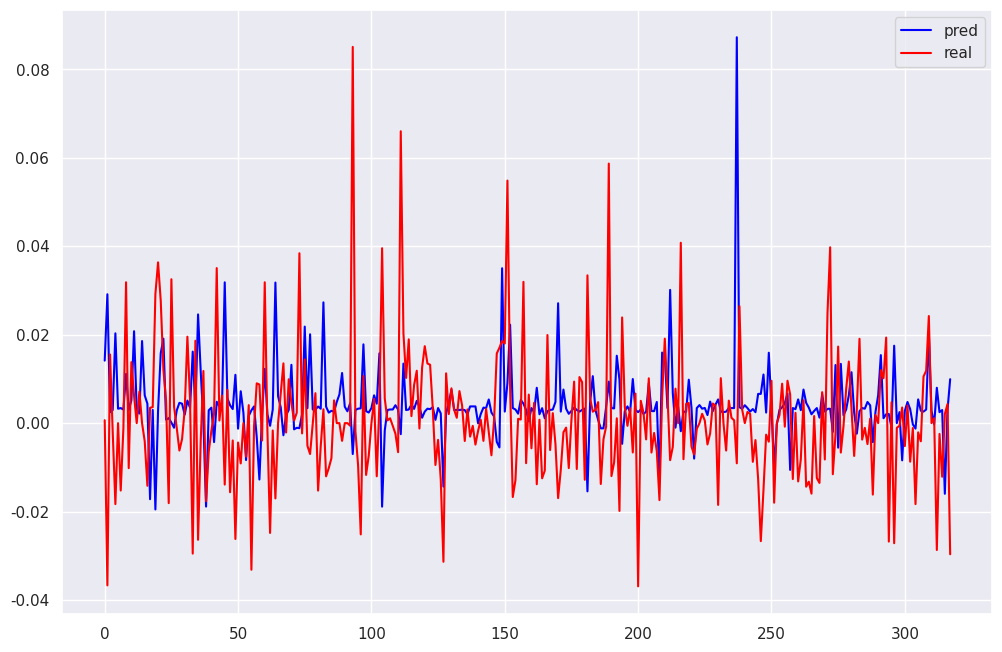

In [121]:
xgboot_reg(features_filtered_0,y)

